In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
%xmode Minimal

Exception reporting mode: Minimal


In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
#import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray.air import session, Checkpoint
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer

from ray.data.datasource import SimpleTorchDatasource
from ray.data.preprocessors import Concatenator, Chain, StandardScaler

from ray import tune
from ray.tune .tuner import Tuner, TuneConfig
from ray.air.config import RunConfig

import matplotlib.pyplot as plt

from ray_cluster_control import start_ray_cluster, stop_ray_cluster

Python-dotenv could not parse statement starting at line 4


In [ ]:
start_ray_cluster()

In [ ]:
ray.init('ray://{ray_head}-ray-head:10001'.format(ray_head=os.environ['RAY_CLUSTER_NAME']))

In [6]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [7]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

In [8]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [9]:
len(pet_data)

3680

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cpu


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


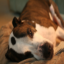

label:1


In [11]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [12]:
def ConvNet():
    return nn.Sequential(
        nn.Conv2d(3, 16, 3, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 3,1 ),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(6272 , 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 37)
    )

In [13]:
net = ConvNet()
net.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=37, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.599599
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.629975
Finished Training


In [17]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

In [18]:
# Now with Ray 

In [19]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

In [ ]:
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.5, shuffle=True)

In [21]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [22]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss = loss_fn(pred, y).item()  
    
    return test_loss
            

In [23]:
def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]
    
    
    train_dataloader = train.get_dataset_shard("train")
    test_dataloader = train.get_dataset_shard("test")
    model = ConvNet()
    model = train.torch.prepare_model(model).to("cuda")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        loss_results.append(loss)
        eval_results.append(val_loss)
        session.report({"loss":loss},)
    
    session.report({"loss":loss, "model": model.state_dict(),
                   "training_loss": loss_results,"eval_loss": eval_results},
                   checkpoint=Checkpoint.from_dict(dict(epoch=epoch, model=model.state_dict())))
            
    

In [24]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config = {
    "batch_size": 4,
    "epochs": 100,
    "momentum": 0.9,
    "lr": 0.001,
    "tune_run": False    
        
    },
    scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = True,
    trainer_resources = {"CPU":1}),
    run_config = RunConfig(
        name = "test_run",
        local_dir = "./",
        sync_config = tune.SyncConfig(syncer=None)),
    datasets = {"train": train_dataset,
               "test":valid_dataset},
    )

In [ ]:
result = trainer.fit()

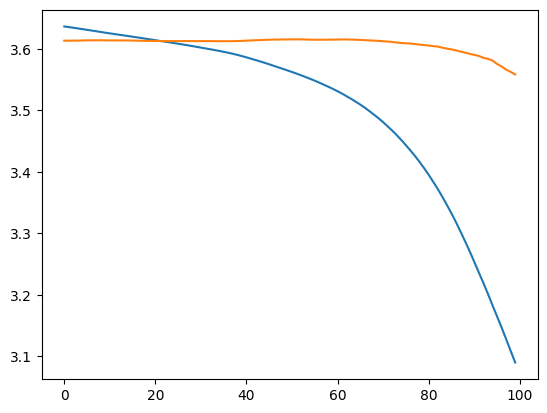

In [26]:
plt.plot(result.metrics["training_loss"])
plt.plot(result.metrics["eval_loss"])
plt.show()

In [27]:
model = result.metrics['model']
torch.save(model ,'ray_model_scripted.pt')

In [28]:
# Tune! 

In [29]:
# Define a search space.
search_space = {"train_loop_config": 
    {"lr": tune.grid_search([0.001, 0.1]),
    "momentum": tune.grid_search([0.1, 0.9]),
    "batch_size": tune.grid_search([4]), 
    "epochs": tune.grid_search([300]),
    "tune_run": tune.grid_search([True])}
}

metric = "loss"

In [30]:
tuner = Tuner(trainer,
              param_space=search_space,
              tune_config=TuneConfig(num_samples=1, metric=metric, mode="min"),
             )

In [ ]:
result_grid = tuner.fit()

In [32]:
best_result = result_grid.get_best_result()
best_model = best_result.metrics["model"]
torch.save(best_model ,'best_ray_model_scripted.pt')

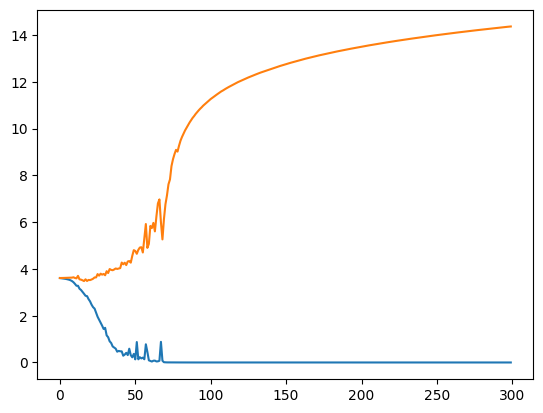

In [33]:
plt.plot(best_result.metrics["training_loss"])
plt.plot(best_result.metrics["eval_loss"])
plt.show()

In [34]:
model = ConvNet()
sd = torch.load("best_ray_model_scripted.pt")
model.load_state_dict(sd)

<All keys matched successfully>

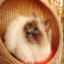

label:6
prediction: 6


In [35]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [36]:
X = []
y = []
y_pred = []

for data in valid_dataset.iter_rows():
    X.append(data[0])
    y.append(data[1])
    logit = model(data[0].reshape(1,3,64,64))
    y_pred.append(torch.argmax(logit))

In [37]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.19      0.16      0.18        55
           1       0.08      0.09      0.09        43
           2       0.03      0.04      0.03        53
           3       0.10      0.07      0.08        59
           4       0.10      0.09      0.09        46
           5       0.05      0.04      0.04        54
           6       0.16      0.15      0.15        47
           7       0.31      0.26      0.29        57
           8       0.07      0.05      0.06        55
           9       0.07      0.07      0.07        45
          10       0.08      0.07      0.07        60
          11       0.05      0.05      0.05        42
          12       0.04      0.04      0.04        47
          13       0.05      0.06      0.06        47
          14       0.02      0.02      0.02        48
          15       0.16      0.11      0.13        57
          16       0.08      0.07      0.08        54
          17       0.06    

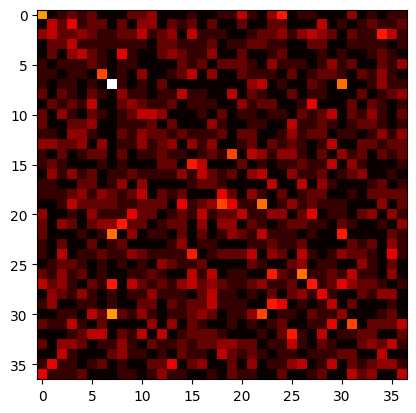

In [38]:
plt.imshow(confusion_matrix(y_pred,y), cmap='hot', interpolation='nearest')
plt.show()

In [39]:
print(f"Accuracy: {np.sum(np.array(y_pred)==np.array(y))/(len(y))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_pred)==np.array(y))/len(y))/(1/37):.2f}")

Accuracy: 8.3%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 3.06


In [40]:
stop_ray_cluster()